# Imports

In [1]:
import cudf
import cudf as pd
import numpy as np
import pandas
import shap
import seaborn as sns
import numpy
import cupy
import tensorflow
import os
import random

from cuml import train_test_split
from cuml.svm import svr
from cuml import RandomForestRegressor as CudaRandomForest
from cuml.metrics import mean_squared_error
from keras import Sequential
from keras.src.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt
from pyswarms.single import GlobalBestPSO
from shap.plots import colors
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

from dask_cuda import LocalCUDACluster
from dask.distributed import Client

SEED = 100


def reset_seed(rnd_seed=SEED):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(rnd_seed)
    numpy.random.seed(rnd_seed)
    cupy.random.seed(rnd_seed)
    tensorflow.random.set_seed(rnd_seed)


cluster = LocalCUDACluster()
client = Client(cluster)
reset_seed()


2024-06-16 23:19:13.004508: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/eduardoalba0/.conda/envs/rapids-24.06/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40947 instead
  warnings.warn(
2024-06-16 23:19:22,461 - distributed.scheduler - INFO - State start
2024-06-16 23:19:22,467 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-nt6nao2f', purging
2024-06-16 23:19:22,490 - distributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:33033
2024-06-16 23:19:22,492 - distributed.scheduler - INFO -   dashboard at:  http://127.0.0.1:40947/status
2024

# Load Datasets

In [2]:
df_water = pd.read_csv('./dataset/water.csv', sep=";", decimal=".", header=0)
df_electricity = pd.read_csv('./dataset/electricity.csv', sep=";", decimal=".", header=0)
df_climatic = pd.read_csv('./dataset/climatic.csv', sep=";", decimal=".", header=0)

df_water["data"] = pd.to_datetime(df_water["data"], format="%d/%m/%Y")
df_electricity["data"] = pd.to_datetime(df_electricity["data"], format="%d/%m/%Y")
df_climatic["data"] = pd.to_datetime(df_climatic["data"], format="%d/%m/%Y")

df_water.set_index("data", inplace=True)
df_electricity.set_index("data", inplace=True)
df_climatic.set_index("data", inplace=True)



# Pré-Processamento
## Dados climáticos faltantes

In [3]:
for index, row in df_climatic[df_climatic.isnull()].to_pandas().iterrows():
    df_mes = df_climatic[df_climatic["mes"] == df_climatic.at[index, "mes"]]
    for col in row.index:
        if pandas.isnull(df_climatic.at[index, col]):
            df_mes.at[index, col] = df_mes[col].sum() / df_mes[col][df_mes[col].isnull() == False].count()
            df_climatic.at[index, col] = df_mes.at[index, col]

## Obtenção dos LAGS

In [4]:
for lag_col in ["consumo"]:
    for i in range(1, 12 + 1):
        lag_eletricity = df_electricity[lag_col].shift(i)
        df_electricity[f'{lag_col}_LAG_' + '{:02d}'.format(i)] = lag_eletricity

        lag_water = df_water[lag_col].shift(i)
        df_water[f'{lag_col}_LAG_' + '{:02d}'.format(i)] = lag_water

## União dos dados climáticos aos dados de consumo

In [5]:
df_water = pd.merge(left=df_water, right=df_climatic, on=["data", "mes", "ano"], how="left")
df_water = df_water.drop("leitura", axis=1)

df_electricity = pd.merge(left=df_electricity, right=df_climatic, on=["data", "mes", "ano"], how="left")
df_electricity = df_electricity.drop("leitura", axis=1)


## Criação das variáveis Dummy (mês e ano)

In [6]:
df_meses = pd.get_dummies(df_electricity["mes"].astype(int), prefix="", prefix_sep="", dtype=int).rename(
    columns={"1": "mes_JAN", "2": "mes_FEV", "3": "mes_MAR", "4": "mes_ABR", "5": "mes_MAI", "6": "mes_JUN",
             "7": "mes_JUL", "8": "mes_AGO", "9": "mes_SET", "10": "mes_OUT", "11": "mes_NOV", "12": "mes_DEZ"}
)
df_anos = pd.get_dummies(df_electricity["ano"].astype(int), prefix="", prefix_sep="", dtype=int).rename(
    columns={"2017": "ano_2017", "2018": "ano_2018", "2019": "ano_2019", "2020": "ano_2020", "2021": "ano_2021",
             "2022": "ano_2022", "2023": "ano_2023", "2024": "ano_2024"}
)
df_electricity = pd.concat([df_electricity, df_meses, df_anos], axis=1)
df_electricity = df_electricity.drop(["mes", "ano"], axis=1)
df_electricity = df_electricity.astype("float32").dropna()

df_meses = pd.get_dummies(df_water["mes"].astype(int), prefix="", prefix_sep="", dtype=int).rename(
    columns={"1": "mes_JAN", "2": "mes_FEV", "3": "mes_MAR", "4": "mes_ABR", "5": "mes_MAI", "6": "mes_JUN",
             "7": "mes_JUL", "8": "mes_AGO", "9": "mes_SET", "10": "mes_OUT", "11": "mes_NOV", "12": "mes_DEZ"}
)
df_anos = pd.get_dummies(df_water["ano"].astype(int), prefix="", prefix_sep="", dtype=int).rename(
    columns={"2017": "ano_2017", "2018": "ano_2018", "2019": "ano_2019", "2020": "ano_2020", "2021": "ano_2021",
             "2022": "ano_2022", "2023": "ano_2023", "2024": "ano_2024"}
)
df_water = pd.concat([df_water, df_meses, df_anos], axis=1)
df_water = df_water.drop(["mes", "ano"], axis=1)
df_water = df_water.astype("float32").dropna()

df_show = df_electricity.to_pandas()
df_show

,consumo,consumo_LAG_01,consumo_LAG_02,consumo_LAG_03,consumo_LAG_04,consumo_LAG_05,consumo_LAG_06,consumo_LAG_07,consumo_LAG_08,consumo_LAG_09,...,mes_NOV,mes_DEZ,ano_2017,ano_2018,ano_2019,ano_2020,ano_2021,ano_2022,ano_2023,ano_2024
data,,,,,,,,,,,,,,,,,,,,,
2018-09-01,21969.0,22575.0,17751.0,20841.0,21095.0,21052.0,18671.0,14487.0,10280.0,18585.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-01,20174.0,21969.0,22575.0,17751.0,20841.0,21095.0,21052.0,18671.0,14487.0,10280.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-01,19998.0,20174.0,21969.0,22575.0,17751.0,20841.0,21095.0,21052.0,18671.0,14487.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-01,20426.0,19998.0,20174.0,21969.0,22575.0,17751.0,20841.0,21095.0,21052.0,18671.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01,10732.0,20426.0,19998.0,20174.0,21969.0,22575.0,17751.0,20841.0,21095.0,21052.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,12207.0,11286.0,11897.0,21955.0,21165.0,16655.0,16964.0,14480.0,15342.0,13555.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2023-12-01,9588.0,12207.0,11286.0,11897.0,21955.0,21165.0,16655.0,16964.0,14480.0,15342.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-01-01,8226.0,9588.0,12207.0,11286.0,11897.0,21955.0,21165.0,16655.0,16964.0,14480.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Análise de Correlações
## Eletricidade
### Correlação com os LAGS

<Axes: >

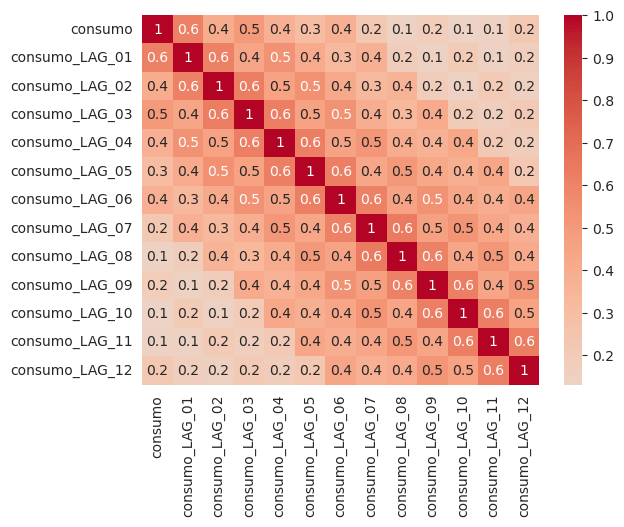

In [7]:
corr_matrix = df_electricity[df_electricity.to_pandas().filter(like="consumo").columns].dropna().to_pandas().corr(
    numeric_only=True)
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.0g')

### Correlação com as variáveis climáticas

<Axes: >

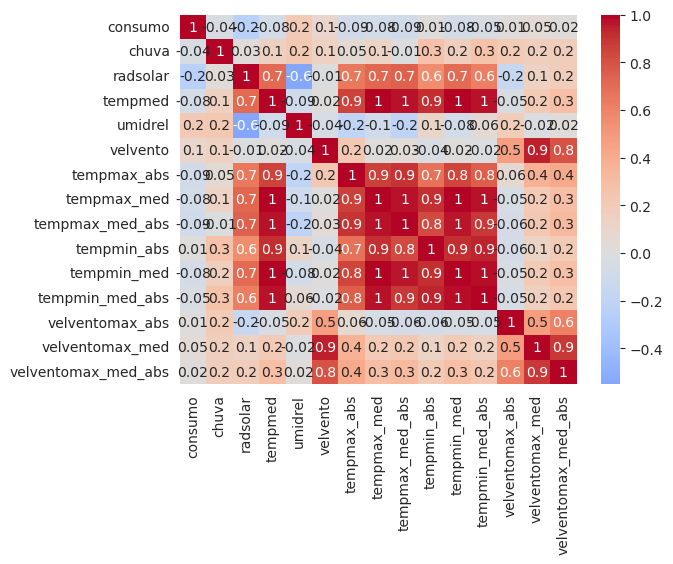

In [8]:
corr_matrix = df_electricity.drop(df_electricity.to_pandas().filter(like="_LAG_").columns,
                                  axis=1).drop(df_electricity.to_pandas().filter(like="mes_").columns,
                                               axis=1).drop(df_electricity.to_pandas().filter(like="ano_").columns,
                                                            axis=1).dropna().to_pandas().corr(numeric_only=True)
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.1g')

## Água
### Correlação com os LAGS

<Axes: >

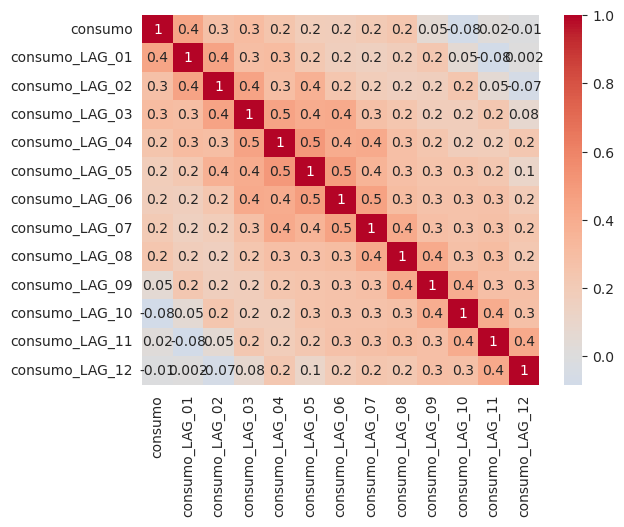

In [9]:
corr_matrix = df_water[df_water.to_pandas().filter(like="consumo").columns].dropna().to_pandas().corr(numeric_only=True)
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.0g')

### Correlação com as variáveis climáticas

<Axes: >

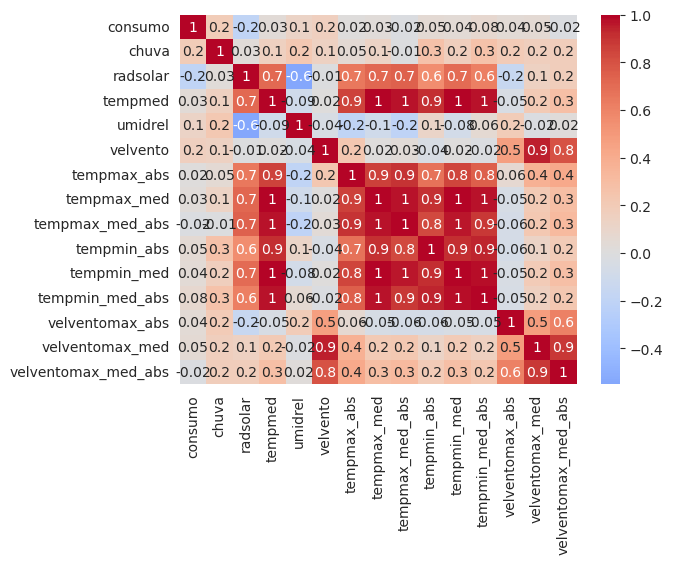

In [10]:
corr_matrix = df_water.drop(df_water.to_pandas().filter(like="_LAG_").columns,
                            axis=1).drop(df_water.to_pandas().filter(like="mes_").columns,
                                         axis=1).drop(df_water.to_pandas().filter(like="ano_").columns,
                                                      axis=1).dropna().to_pandas().corr(numeric_only=True)
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.1g')

## Correlação entre o Consumo de Eletricidade e de Água


<Axes: >

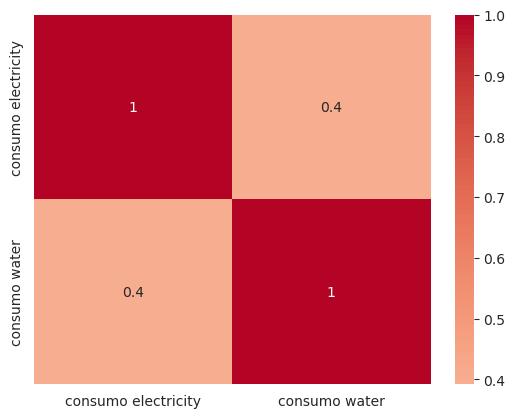

In [11]:
corr_matrix = pd.merge(left=df_electricity["consumo"], right=df_water["consumo"],
                       on=["data"], how="inner",
                       suffixes=[' electricity', ' water']).dropna().to_pandas().corr(numeric_only=True)
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.1g')


# Análise dos SHAP values
## Eletricidade
### Random Forest

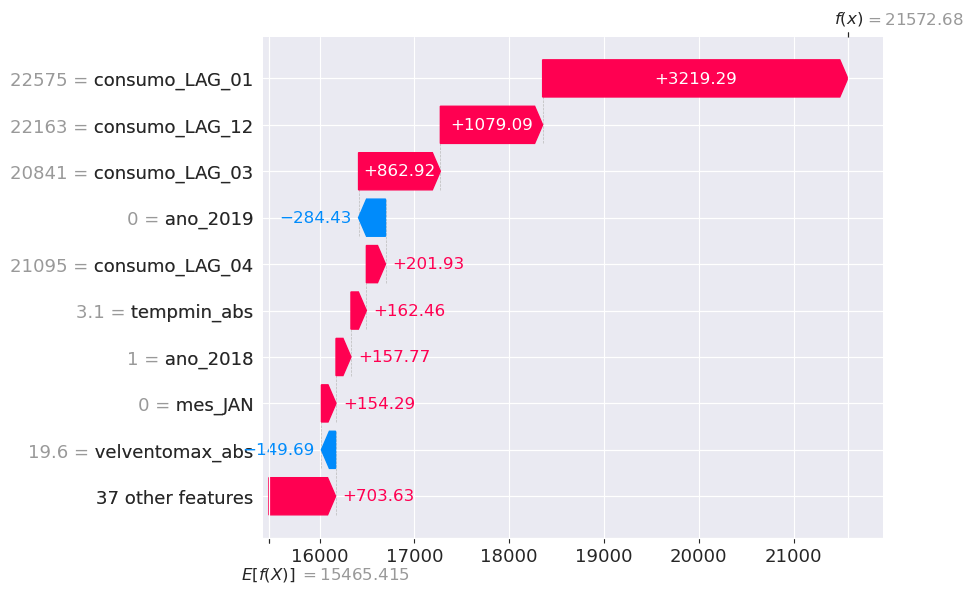

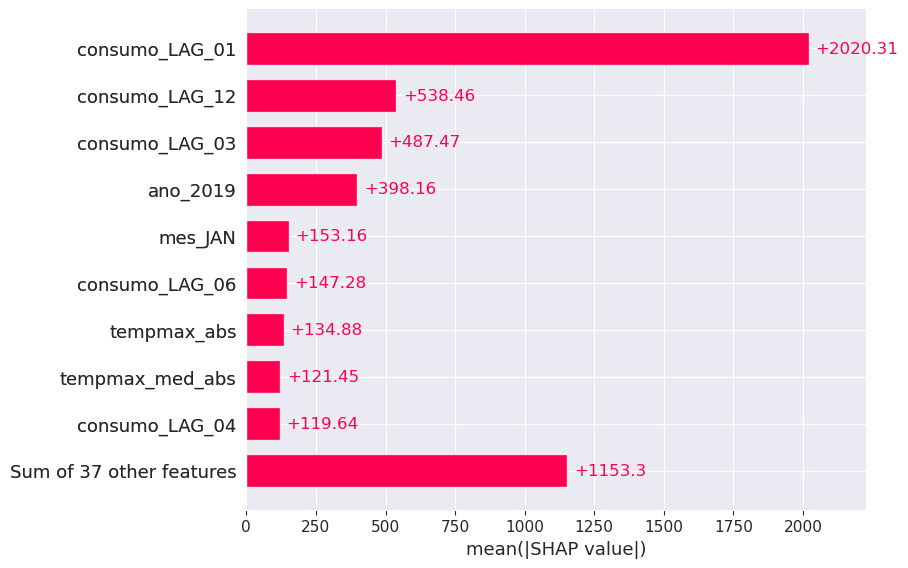

,feature,rf importance
38,ano_2017,0.000000
31,mes_JUN,0.796030
37,mes_DEZ,1.197397
32,mes_JUL,1.232792
33,mes_AGO,1.638126
45,ano_2024,2.315346
35,mes_OUT,2.646474
42,ano_2021,2.826380
44,ano_2023,3.000335
34,mes_SET,3.561569


In [12]:
df_electricity_copy = df_electricity.copy().to_pandas()

x_electricity = df_electricity_copy.drop("consumo", axis=1)
y_electricity = df_electricity_copy["consumo"]
model_rf_electr = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=SEED)
shap.initjs()

model_rf_electr.fit(x_electricity, y_electricity)

explainer_rf_electr = shap.Explainer(model_rf_electr)
shap_rf_electr = explainer_rf_electr(x_electricity)

shap.plots.waterfall(shap_rf_electr[0], max_display=10)
shap.plots.force(shap_rf_electr[0])
shap.plots.bar(shap_rf_electr)

importance_rf_electr = pandas.DataFrame(list(zip(x_electricity.columns, numpy.abs(shap_rf_electr.values).mean(0))),
                                        columns=["feature", "rf importance"])
importance_rf_electr = importance_rf_electr.sort_values(by=["rf importance"])
importance_rf_electr

### XGBoost

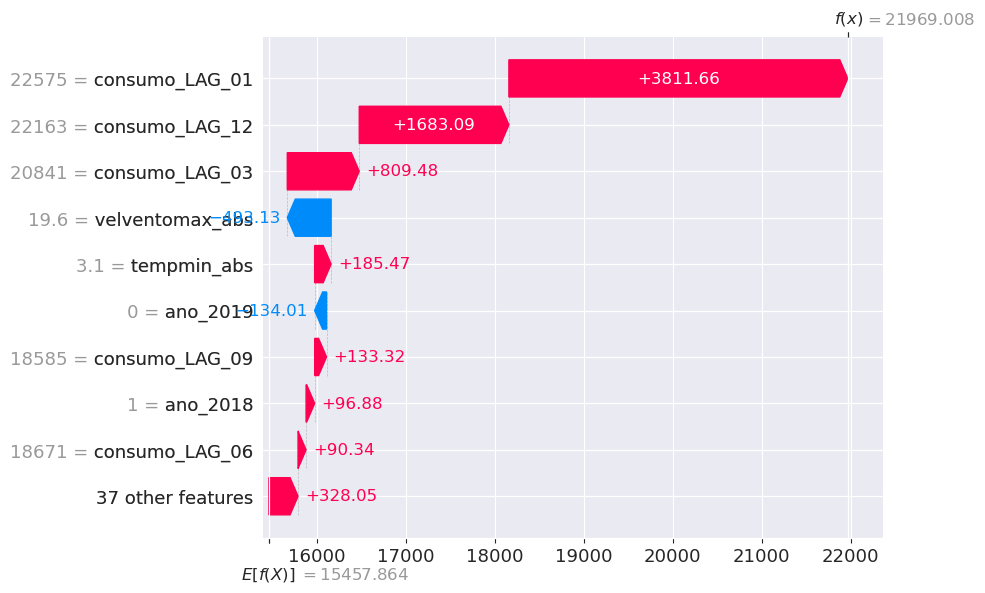

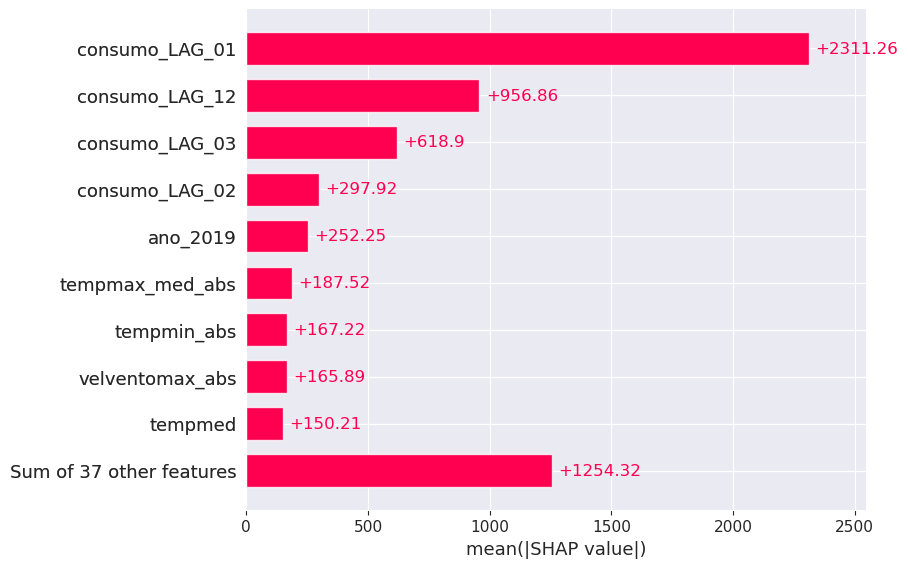

,feature,xgb importance
45,ano_2024,0.000000
32,mes_JUL,0.000000
33,mes_AGO,0.000000
37,mes_DEZ,0.000000
31,mes_JUN,0.000000
42,ano_2021,0.000000
43,ano_2022,0.000000
38,ano_2017,0.000000
21,tempmin_med,0.000039
29,mes_ABR,0.000727


In [13]:
df_electricity_copy = df_electricity.copy().to_pandas()

x_electricity = df_electricity_copy.drop("consumo", axis=1)
y_electricity = df_electricity_copy["consumo"]

model_xgb_electr = XGBRegressor(booster="gbtree", objective='reg:squarederror', random_state=SEED)
shap.initjs()

model_xgb_electr.fit(x_electricity, y_electricity)

explainer_xgb_electr = shap.Explainer(model_xgb_electr)
shap_xgb_electr = explainer_xgb_electr(x_electricity)

shap.plots.waterfall(shap_xgb_electr[0], max_display=10)
shap.plots.force(shap_xgb_electr[0])
shap.plots.bar(shap_xgb_electr)

importance_xgb_electr = pandas.DataFrame(list(zip(x_electricity.columns, numpy.abs(shap_xgb_electr.values).mean(0))),
                                         columns=["feature", "xgb importance"])
importance_xgb_electr = importance_xgb_electr.sort_values(by=["xgb importance"])
importance_xgb_electr

### Média entre RF e XGB

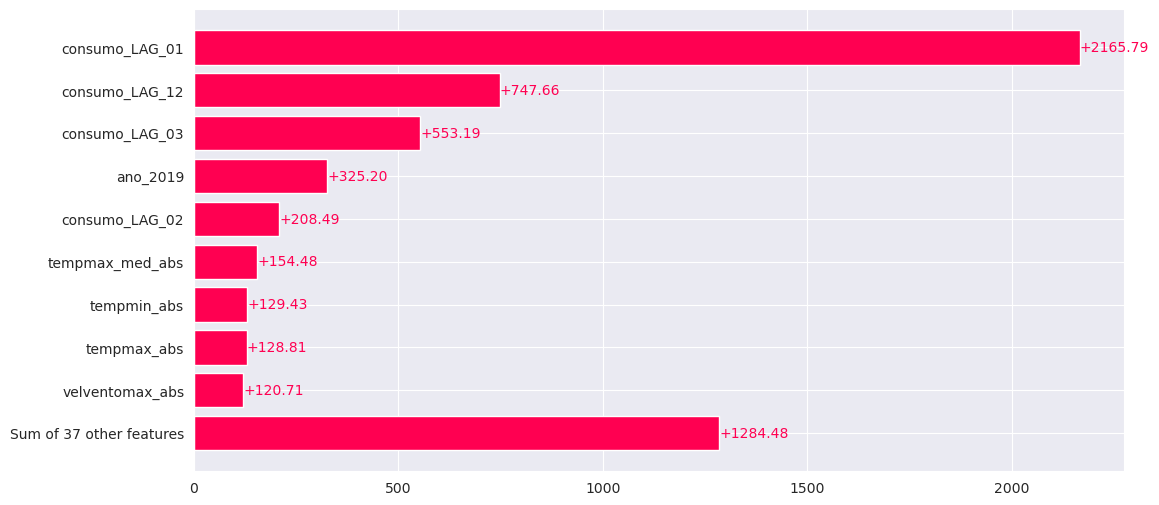

,feature,Mean RF/XGB importance
38,ano_2017,0.000000
31,mes_JUN,0.398015
37,mes_DEZ,0.598698
32,mes_JUL,0.616396
33,mes_AGO,0.819063
45,ano_2024,1.157673
42,ano_2021,1.413190
44,ano_2023,1.515930
30,mes_MAI,2.348043
34,mes_SET,2.463776


In [14]:
importance_electr = pandas.DataFrame(list(zip(x_electricity.columns, (
        numpy.abs(shap_rf_electr.values).mean(0) + numpy.abs(shap_xgb_electr.values).mean(0)) / 2)),
                                     columns=["feature", "Mean RF/XGB importance"])
importance_electr = importance_electr.sort_values(by=["Mean RF/XGB importance"], ascending=False)

plt.figure(figsize=(12, 6))

bar_features_electr = list(importance_electr[0:9]["feature"])
bar_features_electr.append(f"Sum of {len(importance_electr[9:])} other features")
bar_importances_electr = list(importance_electr[0:9]["Mean RF/XGB importance"])
bar_importances_electr.append(importance_electr[9:]["Mean RF/XGB importance"].sum())

bar_features_electr = bar_features_electr[::-1]
bar_importances_electr = bar_importances_electr[::-1]

bars = plt.barh(bar_features_electr, bar_importances_electr, color=colors.red_rgb)

for bar, importance in zip(bars, bar_importances_electr):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'+{importance:.2f}',
             va='center', ha='left', color=colors.red_rgb)

plt.show()
importance_electr = importance_electr.sort_values(by=["Mean RF/XGB importance"])
importance_electr


## Água
### Random Forest

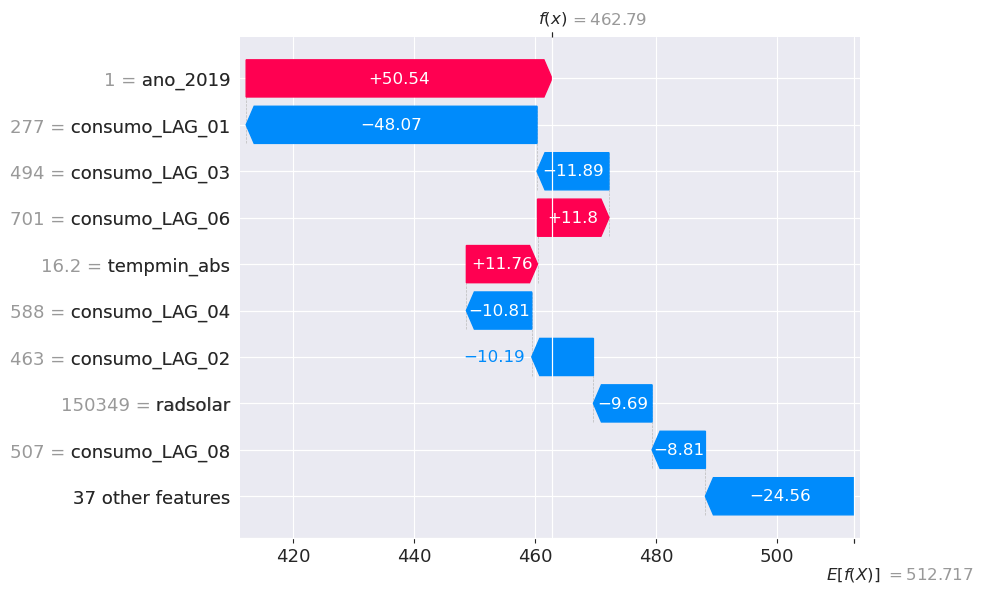

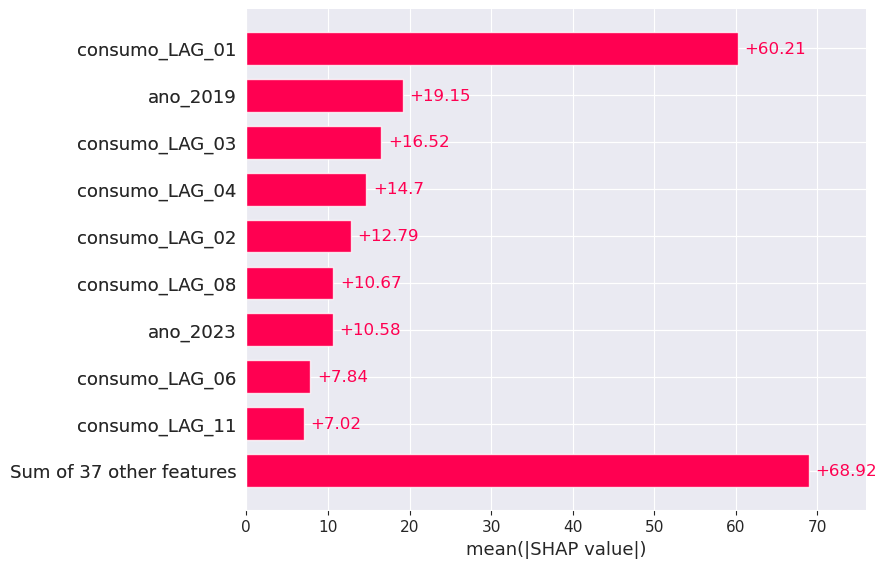

,feature,rf importance
38,ano_2017,0.000000
31,mes_JUN,0.019856
45,ano_2024,0.043247
35,mes_OUT,0.085243
30,mes_MAI,0.142862
36,mes_NOV,0.156889
43,ano_2022,0.218376
39,ano_2018,0.278218
29,mes_ABR,0.339781
33,mes_AGO,0.349453


In [15]:
df_water_copy = df_water.copy().to_pandas()

x_water = df_water_copy.drop("consumo", axis=1)
y_water = df_water_copy["consumo"]
model_rf_water = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=SEED)
shap.initjs()

model_rf_water.fit(x_water, y_water)

explainer_rf_water = shap.Explainer(model_rf_water)
shap_rf_water = explainer_rf_water(x_water)

shap.plots.waterfall(shap_rf_water[0], max_display=10)
shap.plots.force(shap_rf_water[0])
shap.plots.bar(shap_rf_water)

importance_rf_water = pandas.DataFrame(list(zip(x_water.columns, numpy.abs(shap_rf_water.values).mean(0))),
                                       columns=["feature", "rf importance"])
importance_rf_water = importance_rf_water.sort_values(by=["rf importance"])
importance_rf_water


### XGBoost

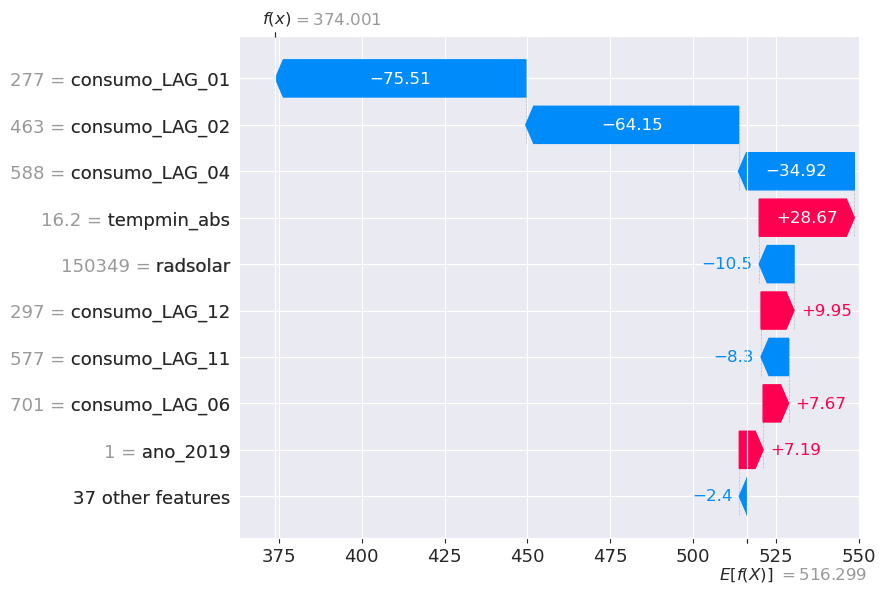

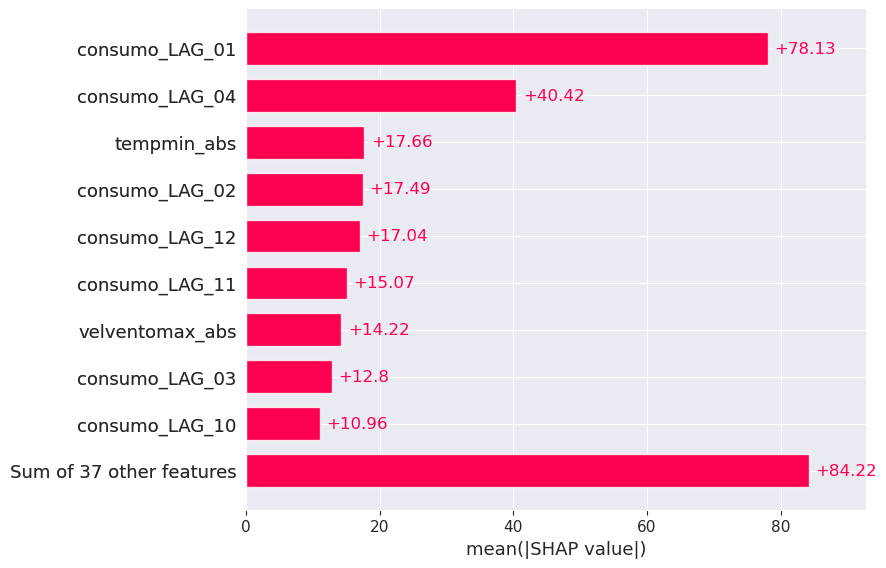

,feature,xgb importance
45,ano_2024,0.000000
28,mes_MAR,0.000000
29,mes_ABR,0.000000
30,mes_MAI,0.000000
35,mes_OUT,0.000000
36,mes_NOV,0.000000
33,mes_AGO,0.000000
38,ano_2017,0.000000
39,ano_2018,0.000000
41,ano_2020,0.000000


In [16]:
df_water_copy = df_water.copy().to_pandas()

x_water = df_water_copy.drop("consumo", axis=1)
y_water = df_water_copy["consumo"]

model_xgb_water = XGBRegressor(booster="gbtree", objective='reg:squarederror', random_state=SEED)
shap.initjs()

model_xgb_water.fit(x_water, y_water)

explainer_xgb_water = shap.Explainer(model_xgb_water)
shap_xgb_water = explainer_xgb_water(x_water)

shap.plots.waterfall(shap_xgb_water[0], max_display=10)
shap.plots.force(shap_xgb_water[0])
shap.plots.bar(shap_xgb_water)

importance_xgb_water = pandas.DataFrame(list(zip(x_water.columns, numpy.abs(shap_xgb_water.values).mean(0))),
                                        columns=["feature", "xgb importance"])
importance_xgb_water = importance_xgb_water.sort_values(by=["xgb importance"])
importance_xgb_water

### Média entre RF e XGB

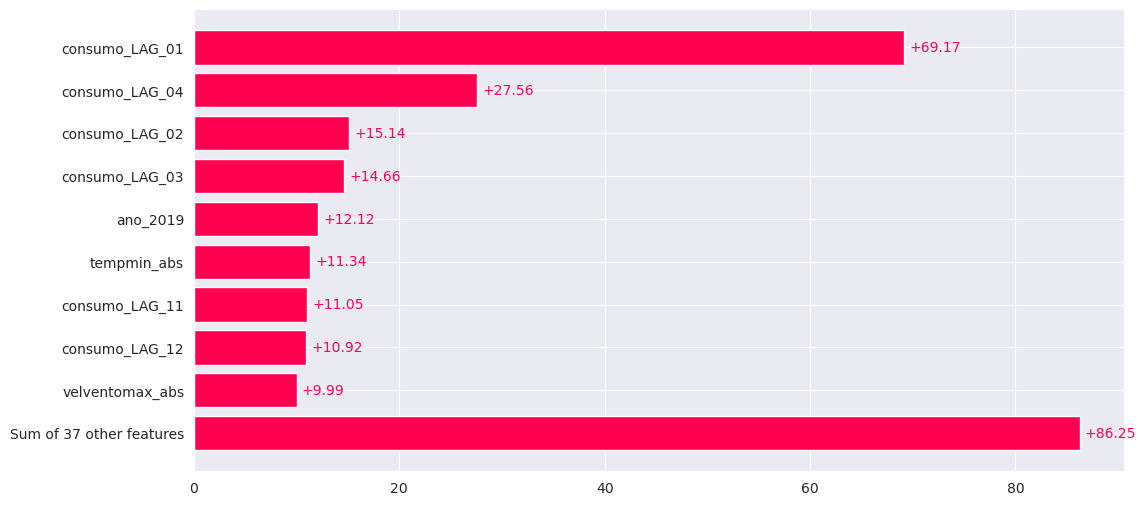

,feature,Mean RF/XGB importance
38,ano_2017,0.000000
31,mes_JUN,0.019831
45,ano_2024,0.021624
35,mes_OUT,0.042622
30,mes_MAI,0.071431
36,mes_NOV,0.078445
43,ano_2022,0.109188
39,ano_2018,0.139109
29,mes_ABR,0.169890
33,mes_AGO,0.174727


In [17]:
importance_water = pandas.DataFrame(list(zip(x_water.columns, (
        numpy.abs(shap_rf_water.values).mean(0) + numpy.abs(shap_xgb_water.values).mean(0)) / 2)),
                                    columns=["feature", "Mean RF/XGB importance"])
importance_water = importance_water.sort_values(by=["Mean RF/XGB importance"], ascending=False)

plt.figure(figsize=(12, 6))

bar_features_water = list(importance_water[0:9]["feature"])
bar_features_water.append(f"Sum of {importance_water[9:].shape[0]} other features")
bar_importances_water = list(importance_water[0:9]["Mean RF/XGB importance"])
bar_importances_water.append(importance_water[9:]["Mean RF/XGB importance"].sum())

bar_features_water = bar_features_water[::-1]
bar_importances_water = bar_importances_water[::-1]

bars = plt.barh(bar_features_water, bar_importances_water, color=colors.red_rgb)

# Display the value of each bar
for bar, importance in zip(bars, bar_importances_water):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'+{importance:.2f}',
             va='center', ha='left', color=colors.red_rgb)

plt.show()
importance_water = importance_water.sort_values(by=["Mean RF/XGB importance"])
importance_water


# Seleção de Features
## Eletricidade

/home/eduardoalba0/.conda/envs/rapids-24.06/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/eduardoalba0/.conda/envs/rapids-24.06/lib/python3.11/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()
/home/eduardoalba0/.conda/envs/rapids-24.06/lib/python3.11/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()
/home/eduardoalba0/.conda/envs/rapi

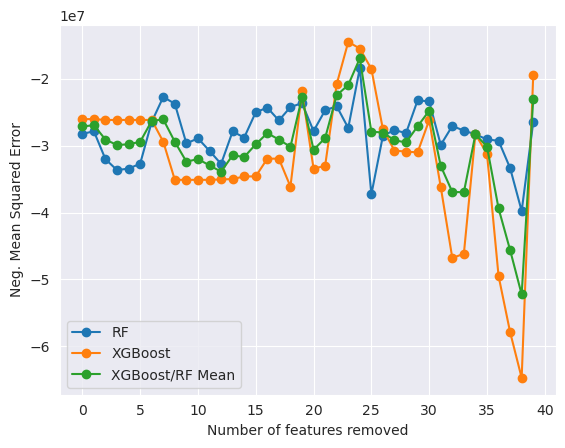

In [18]:
importance_electr = importance_electr.sort_values(by=["Mean RF/XGB importance"])
features_removed_rf_electr = cupy.zeros(importance_electr["feature"].shape[0]).get()
features_removed_xgb_electr = cupy.zeros(importance_electr["feature"].shape[0]).get()

for i in range(importance_electr["feature"].shape[0]):
    df_selected = importance_electr[i:]["feature"]
    x_train, x_test, y_train, y_test = train_test_split(df_electricity[df_selected],
                                                        df_electricity["consumo"].to_cupy(),
                                                        test_size=1, shuffle=False,
                                                        random_state=SEED)

    rf_fs_electr = CudaRandomForest(n_bins=x_train.shape[0], random_state=SEED)
    rf_fs_electr.fit(x_train, y_train)
    features_removed_rf_electr[i] = int(mean_squared_error(y_test, rf_fs_electr.predict(x_test)).get())

    xgb_fs_electr = XGBRegressor(booster="gbtree", device="cuda", random_state=SEED)
    xgb_fs_electr.fit(x_train, y_train)
    features_removed_xgb_electr[i] = int(mean_squared_error(y_test, xgb_fs_electr.predict(x_test)).get())

feature_removed_mean_electr = (features_removed_rf_electr + features_removed_xgb_electr) / 2

plt.plot([-x for x in features_removed_rf_electr[:40]], marker='o', label="RF")
plt.plot([-x for x in features_removed_xgb_electr[:40]], marker='o', label="XGBoost")
plt.plot([-x for x in feature_removed_mean_electr[:40]], marker='o',
         label="XGBoost/RF Mean")
plt.xlabel('Number of features removed')
plt.ylabel('Neg. Mean Squared Error')
plt.legend()
plt.show()



In [39]:
importance_electr = importance_electr.sort_values(by=["Mean RF/XGB importance"])
min_index = np.argmin(feature_removed_mean_electr[:40])
df_electricity_selected = df_electricity.drop(importance_electr[:min_index]["feature"], axis=1)
df_electricity_selected

,consumo,consumo_LAG_01,consumo_LAG_02,consumo_LAG_03,consumo_LAG_04,consumo_LAG_06,consumo_LAG_07,consumo_LAG_08,consumo_LAG_09,consumo_LAG_11,...,tempmax_abs,tempmax_med_abs,tempmin_abs,velventomax_abs,velventomax_med,velventomax_med_abs,mes_JAN,mes_MAR,ano_2019,ano_2020
data,,,,,,,,,,,,,,,,,,,,,
2018-09-01,21969.0,22575.0,17751.0,20841.0,21095.0,18671.0,14487.0,10280.0,18585.0,19732.0,...,30.200001,22.250000,3.100000,19.600000,5.51,9.44,0.0,0.0,0.0,0.0
2018-10-01,20174.0,21969.0,22575.0,17751.0,20841.0,21052.0,18671.0,14487.0,10280.0,20742.0,...,28.799999,22.370001,7.500000,18.000000,5.95,9.95,0.0,0.0,0.0,0.0
2018-11-01,19998.0,20174.0,21969.0,22575.0,17751.0,21095.0,21052.0,18671.0,14487.0,18585.0,...,30.700001,26.120001,11.200000,16.600000,6.44,10.68,0.0,0.0,0.0,0.0
2018-12-01,20426.0,19998.0,20174.0,21969.0,22575.0,20841.0,21095.0,21052.0,18671.0,10280.0,...,31.400000,27.760000,6.900000,19.100000,5.20,10.60,0.0,0.0,0.0,0.0
2019-01-01,10732.0,20426.0,19998.0,20174.0,21969.0,17751.0,20841.0,21095.0,21052.0,14487.0,...,31.799999,28.320000,16.200001,15.800000,5.28,9.74,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,12207.0,11286.0,11897.0,21955.0,21165.0,16964.0,14480.0,15342.0,13555.0,12500.0,...,31.900000,24.910000,4.300000,16.200001,5.39,9.30,0.0,0.0,0.0,0.0
2023-12-01,9588.0,12207.0,11286.0,11897.0,21955.0,16655.0,16964.0,14480.0,15342.0,10272.0,...,33.299999,27.150000,11.800000,15.700000,4.84,8.69,0.0,0.0,0.0,0.0
2024-01-01,8226.0,9588.0,12207.0,11286.0,11897.0,21165.0,16655.0,16964.0,14480.0,13555.0,...,31.000000,26.299999,10.600000,16.700001,5.19,9.21,1.0,0.0,0.0,0.0


## Água

# Configuração dos Otimizadores
## Algoritmo Genético
### Random Forest

In [20]:
class IndRF:
    def __init__(self):
        self.fitness = None
        self.estimators = 0
        self.max_depth = 0
        self.min_samples_split = 0
        self.min_samples_leaf = 0

    def create_random(self):
        self.rand_estimators()
        self.rand_depth()
        self.rand_samples_split()
        self.rand_samples_leaf()
        return self

    def rand_estimators(self):
        self.estimators = random.randint(1, 300)

    def rand_depth(self):
        self.max_depth = random.randint(1, 300)

    def rand_samples_split(self):
        self.min_samples_split = random.randint(2, 50)

    def rand_samples_leaf(self):
        self.min_samples_leaf = random.uniform(1, 50)


class GARF:
    def __init__(self, dataset, n_individuals, n_generations, mutation_rate, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_individuals = n_individuals
        self.n_generations = n_generations
        self.mutation_rate = mutation_rate
        self.population = []
        self.init_pop()
        self.init_gen()

    def init_pop(self):
        for _ in range(self.n_individuals):
            ind = IndRF().create_random()
            ind = self.get_fitness(ind)
            self.population.append(ind)
            self.population = sorted(self.population, key=lambda a: a.fitness)

    def init_gen(self):
        for _ in range(self.n_generations):
            ind_a = self.population[0]
            ind_b = random.choice(self.population)
            ind_c = self.crossover(ind_a, ind_b)
            if random.uniform(0, 1) < self.mutation_rate:
                ind_c = self.mutation(ind_c)
            ind_c = self.get_fitness(ind_c)
            self.population.append(ind_c)
            self.population = sorted(self.population, key=lambda a: a.fitness)

    def mutation(self, ind):
        random.choice([
            ind.rand_estimators(),
            ind.rand_depth(),
            ind.rand_samples_split(),
            ind.rand_samples_leaf(),
        ])
        return ind

    def crossover(self, ind_a, ind_b):
        ind = IndRF()
        ind.estimators = random.choice([ind_a.estimators, ind_b.estimators])
        ind.max_depth = random.choice([ind_a.max_depth, ind_b.max_depth])
        ind.min_samples_split = random.choice([ind_a.min_samples_split, ind_b.min_samples_split])
        ind.min_samples_leaf = random.choice([ind_a.min_samples_leaf, ind_b.min_samples_leaf])
        return ind

    def get_fitness(self, individual):
        x_train, x_test, y_train, y_test = train_test_split(self.dataset.drop("consumo", axis=1),
                                                            self.dataset["consumo"],
                                                            test_size=1, shuffle=False,
                                                            random_state=self.seed)

        model = CudaRandomForest(random_state=self.seed,
                                 n_estimators=individual.estimators,
                                 max_depth=individual.max_depth,
                                 min_samples_split=individual.min_samples_split,
                                 min_samples_leaf=individual.min_samples_leaf,
                                 n_streams=individual.estimators,
                                 n_bins=x_train.shape[0])

        model.fit(x_train, y_train)
        individual.fitness = int(mean_squared_error(y_test, model.predict(x_test)).get())
        return individual

    def population_dataframe(self):
        df = pd.DataFrame()
        for ind in self.population:
            df = pd.concat([df, pd.DataFrame({
                "N_estimators": ind.estimators,
                "Max_depth": ind.max_depth,
                "Min_samples_split": ind.min_samples_split,
                "Min_samples_leaf": ind.min_samples_leaf,
                "Fitness": ind.fitness
            })])
        return df



### XGBoost

In [21]:
class IndXGB:
    def __init__(self):
        self.fitness = None
        self.estimators = 0
        self.max_depth = 0
        self.booster = None
        self.reg_lambda = 0
        self.reg_alpha = 0

    def create_random(self):
        self.rand_estimators()
        self.rand_depth()
        self.rand_booster()
        self.rand_lambda()
        self.rand_alpha()
        return self

    def rand_estimators(self):
        self.estimators = random.randint(1, 300)

    def rand_depth(self):
        self.max_depth = random.randint(1, 300)

    def rand_booster(self):
        self.booster = random.choice(["gbtree", "gblinear", "dart"])

    def rand_lambda(self):
        self.reg_lambda = random.uniform(0, 100)

    def rand_alpha(self):
        self.reg_alpha = random.uniform(0, 100)


class GAXGB:
    def __init__(self, dataset, n_individuals, n_generations, mutation_rate, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_individuals = n_individuals
        self.n_generations = n_generations
        self.mutation_rate = mutation_rate
        self.population = []
        self.init_pop()
        self.init_gen()

    def init_pop(self):
        for _ in range(self.n_individuals):
            ind = IndXGB().create_random()
            ind = self.get_fitness(ind)
            self.population.append(ind)
            self.population = sorted(self.population, key=lambda a: a.fitness)

    def init_gen(self):
        for _ in range(self.n_generations):
            ind_a = self.population[0]
            ind_b = random.choice(self.population)
            ind_c = self.crossover(ind_a, ind_b)
            if random.uniform(0, 1) < self.mutation_rate:
                ind_c = self.mutation(ind_c)
            ind_c = self.get_fitness(ind_c)
            self.population.append(ind_c)
            self.population = sorted(self.population, key=lambda a: a.fitness)

    def mutation(self, ind):
        random.choice([
            ind.rand_estimators(),
            ind.rand_depth(),
            ind.rand_booster(),
            ind.rand_lambda(),
            ind.rand_alpha()
        ])
        return ind

    def crossover(self, ind_a, ind_b):
        ind = IndXGB()
        ind.estimators = random.choice([ind_a.estimators, ind_b.estimators])
        ind.max_depth = random.choice([ind_a.max_depth, ind_b.max_depth])
        ind.booster = random.choice([ind_a.booster, ind_b.booster])
        ind.reg_lambda = random.choice([ind_a.reg_lambda, ind_b.reg_lambda])
        ind.reg_alpha = random.choice([ind_a.reg_alpha, ind_b.reg_alpha])
        return ind

    def get_fitness(self, individual):

        x_train, x_test, y_train, y_test = train_test_split(self.dataset.drop("consumo", axis=1),
                                                            self.dataset["consumo"],
                                                            test_size=1, shuffle=False,
                                                            random_state=self.seed)

        updater = "coord_descent" if individual.booster == "gblinear" else None

        model = XGBRegressor(device="cuda", random_state=self.seed,
                             n_estimators=individual.estimators,
                             max_depth=individual.max_depth,
                             booster=individual.booster,
                             reg_lambda=individual.reg_lambda,
                             reg_alpha=individual.reg_alpha,
                             updater=updater)

        model.fit(x_train, y_train)
        individual.fitness = int(mean_squared_error(y_test, model.predict(x_test)).get())
        return individual

    def population_dataframe(self):
        df = pd.DataFrame()
        for ind in self.population:
            df = pd.concat([df, pd.DataFrame({
                "N_estimators": ind.estimators,
                "Max_depth": ind.max_depth,
                "Booster": ind.booster,
                "Lambda": ind.reg_lambda,
                "Alpha": ind.reg_alpha,
                "Fitness": ind.fitness
            })])
        return df


### SVR

In [22]:
class IndSVR:
    def __init__(self):
        self.fitness = None
        self.c = 0
        self.epsilon = 0
        self.degree = 0
        self.kernel = None
        self.gamma = None

    def create_random(self):
        self.rand_c()
        self.rand_epsilon()
        self.rand_kernel()
        return self

    def rand_c(self):
        self.c = random.uniform(0.001, 300)

    def rand_epsilon(self):
        self.epsilon = random.uniform(0.001, 300)

    def rand_kernel(self):
        self.kernel = random.choice(["poly", "rbf", "sigmoid"])


class GASVR:
    def __init__(self, dataset, n_individuals, n_generations, mutation_rate, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_individuals = n_individuals
        self.n_generations = n_generations
        self.mutation_rate = mutation_rate
        self.population = []
        self.init_pop()
        self.init_gen()

    def init_pop(self):
        for _ in range(self.n_individuals):
            ind = IndSVR().create_random()
            ind = self.get_fitness(ind)
            self.population.append(ind)
            self.population = sorted(self.population, key=lambda a: a.fitness)

    def init_gen(self):
        for _ in range(self.n_generations):
            ind_a = self.population[0]
            ind_b = random.choice(self.population)
            ind_c = self.crossover(ind_a, ind_b)
            if random.uniform(0, 1) < self.mutation_rate:
                ind_c = self.mutation(ind_c)
            ind_c = self.get_fitness(ind_c)
            self.population.append(ind_c)
            self.population = sorted(self.population, key=lambda a: a.fitness)

    def mutation(self, ind):
        random.choice([
            ind.rand_c(),
            ind.rand_epsilon(),
            ind.rand_kernel(),
        ])
        return ind

    def crossover(self, ind_a, ind_b):
        ind = IndSVR()
        ind.c = random.choice([ind_a.c, ind_b.c])
        ind.epsilon = random.choice([ind_a.epsilon, ind_b.epsilon])
        ind.kernel = random.choice([ind_a.kernel, ind_b.kernel])
        return ind

    def get_fitness(self, individual):

        x_train, x_test, y_train, y_test = train_test_split(self.dataset.drop("consumo", axis=1),
                                                            self.dataset["consumo"],
                                                            test_size=1, shuffle=False,
                                                            random_state=self.seed)

        model = svr.SVR(C=individual.c,
                        epsilon=individual.epsilon,
                        kernel=individual.kernel)

        model.fit(x_train, y_train)
        individual.fitness = int(mean_squared_error(y_test, model.predict(x_test)).get())
        return individual

    def population_dataframe(self):
        df = pd.DataFrame()
        for ind in self.population:
            df = pd.concat([df, pd.DataFrame({
                "C": ind.c,
                "Epsilon": ind.epsilon,
                "Kernel": ind.kernel,
                "Fitness": ind.fitness
            })])
        return df


### LSTM

## Enxame de Partículas
### Random Forest

In [23]:
class PartRF:
    def __init_(self):
        self.fitness = None
        self.estimators = 0
        self.max_depth = 0
        self.min_samples_split = 0
        self.min_samples_leaf = 0


class PSORF:
    def __init__(self, dataset, n_particles, n_iters, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_particles = n_particles
        self.n_iters = n_iters
        self.particles = []
        self.run()

    def run(self):
        lower_bound = [1, 1, 2, 1]
        uppper_bound = [300, 300, 50, 50]
        bounds = (lower_bound, uppper_bound)

        options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
        optimizer = GlobalBestPSO(n_particles=self.n_particles,
                                  dimensions=4,
                                  options=options,
                                  bounds=bounds)

        optimizer.optimize(self.get_fitness, iters=self.n_iters)
        self.particles = sorted(self.particles, key=lambda a: a.fitness)

    def get_fitness(self, particles):
        particles = np.round(particles)
        fitness_list = []
        for j in range(self.n_particles):
            fitness_list.append(self.objective_function(particles[j]))
        return fitness_list

    def objective_function(self, particle_arr):
        reset_seed(self.seed)
        particle = PartRF()
        particle.estimators = int(particle_arr[0])
        particle.max_depth = int(particle_arr[1])
        particle.min_samples_split = int(particle_arr[3])
        particle.min_samples_leaf = int(particle_arr[4])

        x_train, x_test, y_train, y_test = train_test_split(self.dataset.drop("consumo", axis=1),
                                                            self.dataset["consumo"],
                                                            test_size=1, shuffle=False,
                                                            random_state=self.seed)

        model = CudaRandomForest(random_state=self.seed,
                                 n_estimators=particle.estimators,
                                 max_depth=particle.max_depth,
                                 min_samples_split=particle.min_samples_split,
                                 min_samples_leaf=particle.min_samples_leaf,
                                 n_streams=particle.estimators,
                                 n_bins=x_train.shape[0])

        model.fit(x_train, y_train)
        particle.fitness = int(mean_squared_error(y_test, model.predict(x_test)).get())

        self.particles.append(particle)
        return particle.fitness

    def particles_dataframe(self):
        df = pd.DataFrame()
        for part in self.particles:
            df = pd.concat([df, pd.DataFrame({
                "N_estimators": part.estimators,
                "Max_depth": part.max_depth,
                "Min_samples_split": part.min_samples_split,
                "Min_samples_leaf": part.min_samples_leaf,
                "Fitness": part.fitness
            })])
        return df


### XGBoost

In [24]:
class PartXGB:
    def __init_(self):
        self.fitness = None
        self.estimators = 0
        self.max_depth = 0
        self.booster = None
        self.reg_lambda = 0
        self.reg_alpha = 0


class PSOXGB:
    def __init__(self, dataset, n_particles, n_iters, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_particles = n_particles
        self.n_iters = n_iters
        self.particles = []
        self.BOOSTERS = ["gbtree", "gblinear", "dart"]
        self.run()

    def run(self):
        lower_bound = [1, 1, 0, 0, 0]
        uppper_bound = [300, 300, 2, 100, 100]
        bounds = (lower_bound, uppper_bound)

        options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
        optimizer = GlobalBestPSO(n_particles=self.n_particles,
                                  dimensions=5,
                                  options=options,
                                  bounds=bounds)

        optimizer.optimize(self.get_fitness, iters=self.n_iters)
        self.particles = sorted(self.particles, key=lambda a: a.fitness)

    def get_fitness(self, particles):
        particles = np.round(particles)
        fitness_list = []
        for j in range(self.n_particles):
            fitness_list.append(self.objective_function(particles[j]))
        return fitness_list

    def objective_function(self, particle_arr):
        reset_seed(self.seed)
        particle = PartXGB()
        particle.estimators = int(particle_arr[0])
        particle.max_depth = int(particle_arr[1])
        particle.booster = self.BOOSTERS[int(particle_arr[2])]
        particle.reg_lambda = particle_arr[3]
        particle.reg_alpha = particle_arr[4]

        updater = "coord_descent" if particle.booster == "gblinear" else None

        x_train, x_test, y_train, y_test = train_test_split(self.dataset.drop("consumo", axis=1),
                                                            self.dataset["consumo"],
                                                            test_size=1, shuffle=False,
                                                            random_state=self.seed)

        model = XGBRegressor(device="cuda", random_state=self.seed,
                             n_estimators=particle.estimators,
                             max_depth=particle.max_depth,
                             booster=particle.booster,
                             reg_lambda=particle.reg_lambda,
                             reg_alpha=particle.reg_alpha,
                             updater=updater)

        model.fit(x_train, y_train)
        particle.fitness = int(mean_squared_error(y_test, model.predict(x_test)).get())

        self.particles.append(particle)
        return particle.fitness

    def particles_dataframe(self):
        df = pd.DataFrame()
        for part in self.particles:
            df = pd.concat([df, pd.DataFrame({
                "N_estimators": part.estimators,
                "Max_depth": part.max_depth,
                "Booster": part.booster,
                "Lambda": part.reg_lambda,
                "Alpha": part.reg_alpha,
                "Fitness": part.fitness
            })])
        return df



### SVR

In [45]:
class PartSVR:
    def __init_(self):
        self.fitness = None
        self.c = 0
        self.epsilon = 0
        self.degree = 0
        self.kernel = None
        self.gamma = None


class PSOSVR:
    def __init__(self, dataset, n_particles, n_iters, seed=SEED):
        reset_seed(seed)
        self.seed = seed
        self.dataset = dataset
        self.n_particles = n_particles
        self.n_iters = n_iters
        self.particles = []
        self.KERNELS = ["poly", "rbf", "sigmoid"]
        self.run()

    def run(self):
        lower_bound = [0.001, 0.001, 0]
        uppper_bound = [300, 300, 2]
        bounds = (lower_bound, uppper_bound)

        options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
        optimizer = GlobalBestPSO(n_particles=self.n_particles,
                                  dimensions=3,
                                  options=options,
                                  bounds=bounds)

        optimizer.optimize(self.get_fitness, iters=self.n_iters)
        self.particles = sorted(self.particles, key=lambda a: a.fitness)

    def get_fitness(self, particles):
        particles = np.round(particles)
        fitness_list = []
        for j in range(self.n_particles):
            fitness_list.append(self.objective_function(particles[j]))
        return fitness_list

    def objective_function(self, particle_arr):
        reset_seed(self.seed)
        particle = PartSVR()
        particle.c = int(particle_arr[0])
        particle.epsilon = int(particle_arr[1])
        particle.kernel = self.KERNELS[int(particle_arr[2])]

        x_train, x_test, y_train, y_test = train_test_split(self.dataset.drop("consumo", axis=1),
                                                            self.dataset["consumo"],
                                                            test_size=1, shuffle=False,
                                                            random_state=self.seed)

        model = svr.SVR(C=particle.c,
                        epsilon=particle.epsilon,
                        kernel=particle.kernel)

        model.fit(x_train, y_train)
        particle.fitness = int(mean_squared_error(y_test, model.predict(x_test)).get())

        self.particles.append(particle)
        return particle.fitness

    def particles_dataframe(self):
        df = pd.DataFrame()
        for part in self.particles:
            df = pd.concat([df, pd.DataFrame({
                "C": part.c,
                "Epsilon": part.epsilon,
                "Kernel": part.kernel,
                "Fitness": part.fitness
            })])
        return df

### LSTM

# Aplicação dos Otimizadores
## Random Forest
### Eletricidade



### Água

## XGBoost
### Eletricidade

### Água

## SVR
### Eletricidade

2024-06-16 23:49:00,965 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|5/5, best_cost=2.45e+7
2024-06-16 23:49:08,239 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 24451500.0, best pos: [47.78748917 40.44400471  0.82135435]


,C,Epsilon,Kernel,Fitness
0,48,40,rbf,24451500
0,48,41,rbf,24458116
0,48,41,rbf,24458116
0,33,63,rbf,24504424
0,38,67,rbf,24511280
0,40,84,rbf,24556138
0,48,41,sigmoid,24601406
0,48,41,sigmoid,24601406
0,60,74,sigmoid,24634850
0,77,78,sigmoid,24682266


### Água

## LSTM
### Eletricidade

### Água

# Previsões
## Eletricidade
### 3 Passos à frente


In [26]:
# reset_seed()
# x_electricity = df_electricity.drop("consumo", axis=1)
# y_electricity = df_electricity["consumo"]
# 
# xgb_electricity = XGBRegressor()
# rf_electricity = CudaRandomForest(n_streams=1, n_bins=x_electricity.shape[0])
# svr_electricity = svr.SVR()
# lstm_electricity = Sequential([
#     Input((x_electricity.shape[1], 1), batch_size=x_electricity.shape[1]),
#     LSTM(30, activation='relu', seed=SEED),
#     Dense(1),
# ])
# lstm_electricity.compile(loss='mse', metrics=['mean_absolute_error'])
# 
# x_train, x_test, y_train, y_test = train_test_split(x_electricity, y_electricity, test_size=3, shuffle=False)
# 
# cvs_electricity = pd.DataFrame()
# for i_train, i_test in TimeSeriesSplit(n_splits=12, test_size=1).split(x_train, y_train):
#     kx_train, kx_test = x_train.iloc[i_train].to_numpy(), x_train.iloc[i_test].to_numpy()
#     ky_train, ky_test = y_train.iloc[i_train].to_numpy(), y_train.iloc[i_test].to_numpy()
# 
#     xgb_electricity.fit(kx_train, ky_train)
#     rf_electricity.fit(kx_train, ky_train)
#     svr_electricity.fit(kx_train, ky_train)
#     lstm_electricity.fit(kx_train, ky_train, shuffle=False, verbose=False, epochs=1, batch_size=x_electricity.shape[1])
#     cvs_electricity = pd.concat([cvs_electricity, pd.DataFrame({
#         "XGB": mean_absolute_percentage_error(xgb_electricity.predict(kx_test), ky_test),
#         "RF": mean_absolute_percentage_error(rf_electricity.predict(kx_test), ky_test),
#         "SVR": mean_absolute_percentage_error(svr_electricity.predict(kx_test), ky_test),
#         "LSTM": mean_absolute_percentage_error(lstm_electricity.predict(kx_test), ky_test)
#     })])
# 
# pred_xgb_electricity = []
# for i_test in range(len(x_test)):
#     sx_test = x_test.iloc[[i_test]]
# 
#     for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
#         sx_test.at[sx_test.index, climatic_column] = \
#             x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
#     for lag in range(i_test + 1):
#         if 'consumo_LAG_' + "{:02d}".format(lag) in sx_test.columns:
#             sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_xgb_electricity[-lag]
# 
#     pred_xgb_electricity.append(xgb_electricity.predict(sx_test.to_numpy())[0])
# 
# pred_rf_electricity = []
# for i_test in range(len(x_test)):
#     sx_test = x_test.iloc[[i_test]]
# 
#     for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
#         sx_test.at[sx_test.index, climatic_column] = \
#             x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
#     for lag in range(i_test + 1):
#         if 'consumo_LAG_' + "{:02d}".format(lag) in sx_test.columns:
#             sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_rf_electricity[-lag]
# 
#     pred_rf_electricity.append(rf_electricity.predict(sx_test.to_numpy())[0])
# 
# pred_svr_electricity = []
# for i_test in range(len(x_test)):
#     sx_test = x_test.iloc[[i_test]]
# 
#     for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
#         sx_test.at[sx_test.index, climatic_column] = \
#             x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
#     for lag in range(i_test + 1):
#         if 'consumo_LAG_' + "{:02d}".format(lag) in sx_test.columns:
#             sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_svr_electricity[-lag]
# 
#     pred_svr_electricity.append(svr_electricity.predict(sx_test.to_numpy())[0])
# 
# pred_lstm_electricity = []
# for i_test in range(len(x_test)):
#     sx_test = x_test.iloc[[i_test]]
# 
#     for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
#         sx_test.at[sx_test.index, climatic_column] = \
#             x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
#     for lag in range(i_test + 1):
#         if 'consumo_LAG_' + "{:02d}".format(lag) in sx_test.columns:
#             sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_lstm_electricity[-lag]
# 
#     pred_lstm_electricity.append(lstm_electricity.predict(sx_test.to_numpy())[0])


### 6 Passos à frente

In [27]:
# reset_seed()
# x_electricity = df_electricity.drop("consumo", axis=1)
# y_electricity = df_electricity["consumo"]
# 
# xgb_electricity = XGBRegressor()
# rf_electricity = CudaRandomForest(n_streams=1, n_bins=x_electricity.shape[0])
# svr_electricity = svr.SVR()
# lstm_electricity = Sequential([
#     Input((x_electricity.shape[1], 1), batch_size=x_electricity.shape[1]),
#     LSTM(30, activation='relu', seed=SEED),
#     Dense(1),
# ])
# lstm_electricity.compile(loss='mse', metrics=['mean_absolute_error'])
# 
# x_train, x_test, y_train, y_test = train_test_split(x_electricity, y_electricity, test_size=6, shuffle=False)
# 
# cvs_electricity = pd.DataFrame()
# for i_train, i_test in TimeSeriesSplit(n_splits=12, test_size=1).split(x_train, y_train):
#     kx_train, kx_test = x_train.iloc[i_train].to_numpy(), x_train.iloc[i_test].to_numpy()
#     ky_train, ky_test = y_train.iloc[i_train].to_numpy(), y_train.iloc[i_test].to_numpy()
# 
#     xgb_electricity.fit(kx_train, ky_train)
#     rf_electricity.fit(kx_train, ky_train)
#     svr_electricity.fit(kx_train, ky_train)
#     lstm_electricity.fit(kx_train, ky_train, shuffle=False, verbose=False, epochs=1, batch_size=x_electricity.shape[1])
#     cvs_electricity = pd.concat([cvs_electricity, pd.DataFrame({
#         "XGB": mean_absolute_percentage_error(xgb_electricity.predict(kx_test), ky_test),
#         "RF": mean_absolute_percentage_error(rf_electricity.predict(kx_test), ky_test),
#         "SVR": mean_absolute_percentage_error(svr_electricity.predict(kx_test), ky_test),
#         "LSTM": mean_absolute_percentage_error(lstm_electricity.predict(kx_test), ky_test)
#     })])
# 
# pred_xgb_electricity = []
# for i_test in range(len(x_test)):
#     sx_test = x_test.iloc[[i_test]]
# 
#     for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
#         sx_test.at[sx_test.index, climatic_column] = \
#             x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
#     for lag in range(i_test + 1):
#         if 'consumo_LAG_' + "{:02d}".format(lag) in sx_test.columns:  
#             sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_xgb_electricity[-lag]
# 
#     pred_xgb_electricity.append(xgb_electricity.predict(sx_test.to_numpy())[0])
# 
# pred_rf_electricity = []
# for i_test in range(len(x_test)):
#     sx_test = x_test.iloc[[i_test]]
# 
#     for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
#         sx_test.at[sx_test.index, climatic_column] = \
#             x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
#     for lag in range(i_test + 1):
#         if 'consumo_LAG_' + "{:02d}".format(lag) in sx_test.columns:  
#             sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_rf_electricity[-lag]
# 
#     pred_rf_electricity.append(rf_electricity.predict(sx_test.to_numpy())[0])
# 
# pred_svr_electricity = []
# for i_test in range(len(x_test)):
#     sx_test = x_test.iloc[[i_test]]
# 
#     for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
#         sx_test.at[sx_test.index, climatic_column] = \
#             x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
#     for lag in range(i_test + 1):
#         if 'consumo_LAG_' + "{:02d}".format(lag) in sx_test.columns:  
#             sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_svr_electricity[-lag]
# 
#     pred_svr_electricity.append(svr_electricity.predict(sx_test.to_numpy())[0])
# 
# pred_lstm_electricity = []
# for i_test in range(len(x_test)):
#     sx_test = x_test.iloc[[i_test]]
# 
#     for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
#         sx_test.at[sx_test.index, climatic_column] = \
#             x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
#     for lag in range(i_test + 1):
#         if 'consumo_LAG_' + "{:02d}".format(lag) in sx_test.columns:  
#             sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_lstm_electricity[-lag]
# 
#     pred_lstm_electricity.append(lstm_electricity.predict(sx_test.to_numpy())[0])


### 12 Passos à frente

In [28]:
# reset_seed()
# x_electricity = df_electricity.drop("consumo", axis=1)
# y_electricity = df_electricity["consumo"]
# 
# xgb_electricity = XGBRegressor()
# rf_electricity = CudaRandomForest(n_streams=1, n_bins=x_electricity.shape[0])
# svr_electricity = svr.SVR()
# lstm_electricity = Sequential([
#     Input((x_electricity.shape[1], 1), batch_size=x_electricity.shape[1]),
#     LSTM(30, activation='relu', seed=SEED),
#     Dense(1),
# ])
# lstm_electricity.compile(loss='mse', metrics=['mean_absolute_error'])
# 
# x_train, x_test, y_train, y_test = train_test_split(x_electricity, y_electricity, test_size=12, shuffle=False)
# 
# cvs_electricity = pd.DataFrame()
# for i_train, i_test in TimeSeriesSplit(n_splits=12, test_size=1).split(x_train, y_train):
#     kx_train, kx_test = x_train.iloc[i_train].to_numpy(), x_train.iloc[i_test].to_numpy()
#     ky_train, ky_test = y_train.iloc[i_train].to_numpy(), y_train.iloc[i_test].to_numpy()
# 
#     xgb_electricity.fit(kx_train, ky_train)
#     rf_electricity.fit(kx_train, ky_train)
#     svr_electricity.fit(kx_train, ky_train)
#     lstm_electricity.fit(kx_train, ky_train, shuffle=False, verbose=False, epochs=1, batch_size=x_electricity.shape[1])
#     cvs_electricity = pd.concat([cvs_electricity, pd.DataFrame({
#         "XGB": mean_absolute_percentage_error(xgb_electricity.predict(kx_test), ky_test),
#         "RF": mean_absolute_percentage_error(rf_electricity.predict(kx_test), ky_test),
#         "SVR": mean_absolute_percentage_error(svr_electricity.predict(kx_test), ky_test),
#         "LSTM": mean_absolute_percentage_error(lstm_electricity.predict(kx_test), ky_test)
#     })])
# 
# pred_xgb_electricity = []
# for i_test in range(len(x_test)):
#     sx_test = x_test.iloc[[i_test]]
# 
#     for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
#         sx_test.at[sx_test.index, climatic_column] = \
#             x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
#     for lag in range(i_test + 1):
#         if 'consumo_LAG_' + "{:02d}".format(lag) in sx_test.columns:  
#             sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_xgb_electricity[-lag]
# 
#     pred_xgb_electricity.append(xgb_electricity.predict(sx_test.to_numpy())[0])
# 
# pred_rf_electricity = []
# for i_test in range(len(x_test)):
#     sx_test = x_test.iloc[[i_test]]
# 
#     for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
#         sx_test.at[sx_test.index, climatic_column] = \
#             x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
#     for lag in range(i_test + 1):
#         if 'consumo_LAG_' + "{:02d}".format(lag) in sx_test.columns:  
#             sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_rf_electricity[-lag]
# 
#     pred_rf_electricity.append(rf_electricity.predict(sx_test.to_numpy())[0])
# 
# pred_svr_electricity = []
# for i_test in range(len(x_test)):
#     sx_test = x_test.iloc[[i_test]]
# 
#     for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
#         sx_test.at[sx_test.index, climatic_column] = \
#             x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
#     for lag in range(i_test + 1):
#         if 'consumo_LAG_' + "{:02d}".format(lag) in sx_test.columns:  
#             sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_svr_electricity[-lag]
# 
#     pred_svr_electricity.append(svr_electricity.predict(sx_test.to_numpy())[0])
# 
# pred_lstm_electricity = []
# for i_test in range(len(x_test)):
#     sx_test = x_test.iloc[[i_test]]
# 
#     for climatic_column in df_climatic.drop(["ano", "mes"], axis=1).columns:
#         sx_test.at[sx_test.index, climatic_column] = \
#             x_electricity.at[(sx_test.index - pd.DateOffset(years=1)), climatic_column].to_numpy()[0][0]
#     for lag in range(i_test + 1):
#         if 'consumo_LAG_' + "{:02d}".format(lag) in sx_test.columns:  
#             sx_test['consumo_LAG_' + "{:02d}".format(lag)] = pred_lstm_electricity[-lag]
# 
#     pred_lstm_electricity.append(lstm_electricity.predict(sx_test.to_numpy())[0])


## Água
### 3 Passos à frente

### 6 Passos à frente

12 Passos à frente